Competition Overview : <br>
https://www.kaggle.com/c/nfl-big-data-bowl-2020/overview <br>

Notebooks Referenced : <br>
https://www.kaggle.com/bestpredict/location-eda-8eb410 <br>
https://www.kaggle.com/mrkmakr/neural-network-with-mae-objective-0-01381


In [11]:
import numpy as np
import pandas as pd

import math

import os
import sklearn.metrics as mtr
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

from keras.layers import Dense,Input,Flatten,concatenate,Dropout,Lambda,BatchNormalization, Activation
from keras.models import Model, Sequential
import keras.backend as K
from keras.callbacks import Callback
from  keras.callbacks import EarlyStopping,ModelCheckpoint
import datetime

from scipy.spatial import Voronoi,voronoi_plot_2d


from tqdm import tqdm

In [2]:
pd.set_option('display.max_columns', 250)
pd.set_option('display.max_rows', 20)

In [3]:
#Read Data
train_df = pd.read_csv('train.csv', low_memory=False)
print(train_df.shape)

(682154, 49)


In [4]:
train_df.Season.value_counts()

2017    261800
2018    247962
2019    172392
Name: Season, dtype: int64

In [5]:
train_df.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,496723,Eric Berry,29,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,212,12/29/1988,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,2495116,Allen Bailey,97,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,288,03/25/1989,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,2495493,Justin Houston,50,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,270,01/21/1989,Georgia,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,2506353,Derrick Johnson,56,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,245,11/22/1982,Texas,ILB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,2530794,Ron Parker,38,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,206,08/17/1987,Newberry,FS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682154 entries, 0 to 682153
Data columns (total 49 columns):
GameId                    682154 non-null int64
PlayId                    682154 non-null int64
Team                      682154 non-null object
X                         682154 non-null float64
Y                         682154 non-null float64
S                         682154 non-null float64
A                         682154 non-null float64
Dis                       682154 non-null float64
Orientation               682131 non-null float64
Dir                       682126 non-null float64
NflId                     682154 non-null int64
DisplayName               682154 non-null object
JerseyNumber              682154 non-null int64
Season                    682154 non-null int64
YardLine                  682154 non-null int64
Quarter                   682154 non-null int64
GameClock                 682154 non-null object
PossessionTeam            682154 non-null object
Down   

In [8]:
#欠損値チェック
for c in train_df.columns:
    if train_df[c].isnull().any():
        print(c, train_df[c].isnull().sum())

Orientation 23
Dir 28
FieldPosition 8602
OffenseFormation 88
DefendersInTheBox 22
StadiumType 41690
GameWeather 60170
Temperature 63646
Humidity 6160
WindSpeed 91872
WindDirection 104676


In [6]:
#Abbreviationの統一
train_df.loc[train_df.HomeTeamAbbr.values == "ARI", 'HomeTeamAbbr'] = "ARZ"
train_df.loc[train_df.HomeTeamAbbr.values == "BAL", 'HomeTeamAbbr'] = "BLT"
train_df.loc[train_df.HomeTeamAbbr.values == "CLE", 'HomeTeamAbbr'] = "CLV"
train_df.loc[train_df.HomeTeamAbbr.values == "HOU", 'HomeTeamAbbr'] = "HST"

#S and A standardization
train_df.loc[train_df['Season'] == 2017, 'S'] = (train_df['S'][train_df['Season'] == 2017] - 2.4355)/1.2930 * 1.4551 + 2.7570
train_df.loc[train_df['Season'] == 2017, 'A'] = (train_df['A'][train_df['Season'] == 2017] - 1.5896)/0.8795 * 1.0603 + 1.7820

## Data Cleansing Functions

In [12]:
#Data Cleansing mostly for categorical data

def strtoseconds(txt):
    txt = txt.split(':')
    ans = int(txt[0])*60 + int(txt[1]) + int(txt[2])/60
    return ans

# weather data encoding
# manually weighted in the following order
# indoor > sunny > clear > unknown > cloudy > rainy > snow
def map_weather(txt):
    ans = 1
    
    if pd.isna(txt):
        ans = 0 #nanであれば0
        
    if 'partly' in txt:
        ans *= 0.5
        
    if 'climate controlled' in txt or 'indoor' in txt:
        return ans*3
    
    if 'sunny' in txt or 'sun' in txt:
        return ans*2
    
    if 'clear' in txt:
        return ans
    
    if 'cloudy' in txt:
        return -ans
    
    if 'rain' in txt or 'rainy' in txt or 'shower' in txt:
        return -2*ans
    
    if 'snow' in txt:
        return -3*ans
    
    return 0


#cleaning wind speed
def clean_wind_speed(windspeed):
    ws = str(windspeed)
    
    if ws.isdigit():
        return int(ws)
    if '-' in ws:
        return np.mean([int(i) for i in ws.split('-') ])
    
    if ws.split(' ')[0].isdigit():
        return int(ws.split(' ')[0])
    
    if 'mph' in ws.lower():
        return int(ws.lower().split('mph')[0])
    
    else:
        return 0
    
def clean_wind_direction(wind_direction):
    wd = str(wind_direction).upper()
    if wd == 'N' or 'FROM S' in wd:
        return 'north'
    if wd == 'S' or 'FROM N' in wd:
        return 'south'
    if wd == 'W' or 'FROM E' in wd:
        return 'west'
    if wd == 'E' or 'FROM W' in wd:
        return 'east'
    
    if 'FROM SW' in wd or 'FROM SSW' in wd or 'FROM WSW' in wd:
        return 'north east'
    if 'FROM SE' in wd or 'FROM SSE' in wd or 'FROM ESE' in wd:
        return 'north west'
    if 'FROM NW' in wd or 'FROM NNW' in wd or 'FROM WNW' in wd:
        return 'south east'
    if 'FROM NE' in wd or 'FROM NNE' in wd or 'FROM ENE' in wd:
        return 'south west'
    
    if 'NW' in wd or 'NORTHWEST' in wd:
        return 'north west'
    if 'NE' in wd or 'NORTH EAST' in wd:
        return 'north east'
    if 'SW' in wd or 'SOUTHWEST' in wd:
        return 'south west'
    if 'SE' in wd or 'SOUTHEAST' in wd:
        return 'south east'

    return 'none'

#cleaning turf/ categorize into 3-classes [natural, artificial, UNKNOWN]
def clean_turf(turf):
    natural = ['Grass', 'Natural Grass', 'DD GrassMaster', 'SISGrass',
              'Natural grass', 'Natural', 'Naturall Grass', 'natural grass', 'grass', 'natural']
    artificial = ['Field Turf', 'Artificial', 'FieldTurf', 'UBU Speed Series-S5-M',
                 'A-Turf Titan', 'UBU Sports Speed S5-M', 'FieldTurf360', 'FieldTurf 360',
                 'Twenty-Four/Seven Turf', 'Artifical', 'Field turf', 'artificial']
    
    if turf in natural:
        return 0
    elif turf in artificial:
        return 1
    else:
        return 0.5

## Helper Functions

In [ ]:
def euclid_distance(X, Y):
    X = np.array(X)
    Y = np.array(Y)
    distance = ((X - Y)**2).sum()
    
    return np.sqrt(distance)

def get_height(txt):
    feet = int(txt.split('-')[0])
    inch = int(txt.split('-')[1])
    
    return feet + np.round(inch/12, 2)


#for voronoi features
def centeroidnp(arr):
    length = arr.shape[0]
    x = arr[:, 0]
    y = arr[:, 1]
    
    x_mean = x.mean()
    y_mean = y.mean()
    
    if not np.isfinite(x_mean):
        x_mean = 0
        
    if not np.isfinite(y_mean):
        y_mean = 0
    
    return x_mean, y_mean

def vertices_std(arr):
    length = arr.shape[0]
    x = arr[:, 0]
    y = arr[:, 1]
    
    x_std = x.std()
    y_std = y.std()
    
    if not np.isfinite(x_std):
        x_std = 0
        
    if not np.isfinite(y_std):
        y_std = 0
    
    return x_std, y_std




def cos_similarity(ax, ay, bx, by):
    a = np.array([ax, ay]).reshape(1, -1)
    b = np.array([bx, by]).reshape(1, -1)
    
    return cosine_similarity(a, b)[0][0]


def area_triangle(a, b, c):
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    
    ab = b - a
    ac = c - a
    
    return 0.5*abs(ab[0]*ac[1] - ab[1]*ac[0])

def standardize_vor(vertices):
    v_std = []
    for v in vertices:
        if v[0] > 120 or v[0] < 0:
            continue
        if v[1] > 53.3 or v[1] < 0:
            continue
        v_std.append(list(v))
        
    return np.array(v_std)

## Functions for Offensive Features
* Player Postions
* Running Back's speed
* TimeSnap - TimeHandoff
* Player Weight/Height avg, std
* Yards need for 1st down
* How much distance away from the touchdown line(might have effects on players' motivation)

In [8]:
#Offence要員のポジション内訳
def OffensePersonnelSplit(x):
    dic = {'DB' : 0, 'DL' : 0, 'LB' : 0, 'OL' : 0, 'QB' : 0, 'RB' : 0, 'TE' : 0, 'WR' : 0, 'IRR': 0}
    for xx in x.split(","):
        xxs = xx.split(" ")
        if xxs[-1] not in dic.keys():
            dic['IRR'] = int(xxs[-2])
        else:
            dic[xxs[-1]] = int(xxs[-2])
    return dic


def OffenseFormationMap(formation):
    dic = {'SINGLEBACK': 0, 'SHOTGUN': 0, 'I_FORM': 0, 'PISTOL': 0, 'JUMBO': 0, 'WILDCAT': 0, 'EMPTY': 0}
    
    if pd.isna(formation):
        dic['EMPTY'] = 1
    else:
        fm = str(formation)
        if fm not in dic.keys():
            dic['EMPTY'] = 1
        else: 
            dic[fm] = 1
        
    return dic
    

## Functions for Deffensive Features


In [9]:
def DefensePersonnelSplit(x):
    dic = {'DB': 0, 'DL': 0, 'LB': 0, 'OL': 0, 'IRR': 0}
    for xx in x.split(','):
        xxs = xx.split(' ')
        if xxs[-1] not in dic.keys():
            dic['IRR'] = int(xxs[-2])
        else:
            dic[xxs[-1]] = int(xxs[-2])
        
    return dic

## Create X

In [10]:
#欠損値補完用
humidity_avg = train_df['Humidity'].mean()
temp_avg = train_df['Temperature'].mean()
avg_rusher_speed = train_df[train_df['NflId'] == train_df['NflIdRusher']]['S'].mean()

print(humidity_avg, temp_avg)
print(avg_rusher_speed)

54.74156279493605 62.01006615920893
4.508322606942699


In [11]:
def get_data(train, mode='train'):
    data_df = pd.DataFrame()
    df = pd.Series()
    
    
    playid_list = train['PlayId'].unique()
    
    for playid in tqdm(playid_list):
        df_playid = train.query('PlayId == @playid')
        df_playid['ToLeft'] = df_playid.PlayDirection == 'left'
        #2018のみ学習につかう場合
#         if df_playid['Season'].iloc[0] == 2017:
#             continue
        
#         if mode == 'train':
#             if df_playid['Yards'].iloc[0] > 90:
#                 continue

        for c in df_playid.columns:
            if df_playid[c].isnull().any():
                df_playid[c] = df_playid[c].fillna(df_playid[c].mean())
        
        """Standardize"""
        df['GameId'] = df_playid['GameId'].iloc[0]
        df['PlayId'] = int(playid)
        play_direction = df_playid['PlayDirection'].iloc[0]
        
        if play_direction == 'left':
            df_playid['X'] = 120.0 - df_playid['X']
            df_playid['Y'] = 53.3 - df_playid['Y']
        
        df_playid['Dir_rad'] = np.mod(90 - df_playid.Dir, 360) * math.pi/180.0
        #df_playid.loc[df_playid.Season >= 2018, 'Dir_rad'] = np.mod(df_playid.loc[df_playid.Season >= 2018, 'Dir']-90, 360) * math.pi/180.0
        if play_direction == 'left':
            df_playid['Dir_rad'] = np.mod(np.pi + df_playid['Dir_rad'], 2*np.pi)
        
        df_playid['Orientation_rad'] = np.mod(df_playid.Orientation, 360) * math.pi/180.0
        df_playid.loc[df_playid.Season >= 2018, 'Orientation_rad'] = np.mod(df_playid.loc[df_playid.Season >= 2018, 'Orientation']-90, 360) * math.pi/180.0
        if play_direction == 'left':
            df_playid['Orientation_rad'] = np.mod(np.pi + df_playid['Orientation_rad'], 2*np.pi)
        
        if df_playid['PossessionTeam'].iloc[0] == df_playid['FieldPosition'].iloc[0]:
            df_playid['YardLine'] = df_playid['YardLine']
        else :
            df_playid['YardLine'] = 100 - df_playid['YardLine']
            
        

        """
        Game Condition Features
        """
        df['GameWeather'] = map_weather(str(df_playid['GameWeather'].iloc[0]).lower())
        df['Turf'] = clean_turf(df_playid['Turf'].iloc[0])
        #df['WindSpeed'] = clean_wind_speed(df_playid['WindSpeed'].iloc[0])
        #df['WindDirection'] = clean_wind_direction(df_playid['WindDirection'].iloc[0])
        
        if pd.isna(df_playid['Humidity'].iloc[0]):
            df['Humidity'] = humidity_avg
        else:
            df['Humidity'] = df_playid['Humidity'].iloc[0]

        if pd.isna(df_playid['Temperature'].iloc[0]):
            df['Temperature'] = temp_avg
        else:
            df['Temperature'] = df_playid['Temperature'].iloc[0]
            
        
        df['GameClock'] = strtoseconds(df_playid['GameClock'].iloc[0])
        
        
        if df_playid['Season'].iloc[0] < 2018:
            df['Season'] = 0
        else:
            df['Season'] = 1
            
        df['Quarter'] = df_playid['Quarter'].iloc[0]
        df['Down'] = df_playid['Down'].iloc[0]
        
        
        
        
        """
        Offensive Features
        """
        rusher = df_playid['NflIdRusher'].iloc[0]
        offense_team = df_playid[df_playid['NflId'] == rusher]['Team'].iloc[0]
        df_offense = df_playid.query('Team == @offense_team')
        
        #攻めチームのリード情報
        if offense_team == 'home':
            df['ScoreDiff'] = df_playid['HomeScoreBeforePlay'].iloc[0] - df_playid['VisitorScoreBeforePlay'].iloc[0]
        else:
            df['ScoreDiff'] = df_playid['VisitorScoreBeforePlay'].iloc[0] - df_playid['HomeScoreBeforePlay'].iloc[0]
        
        
        
        off_centroid = (df_offense['X'].mean(), df_offense['Y'].mean())
        

        off_Ori = df_offense['Orientation_rad'].mean()
        off_Dir = df_offense['Dir_rad'].mean()
        rusher_Ori = df_offense[df_offense['NflId'] == rusher]['Orientation_rad'].iloc[0]
        rusher_Dir = df_offense[df_offense['NflId'] == rusher]['Dir_rad'].iloc[0] 


        rusher_X = df_playid[df_playid['NflId'] == rusher]['X'].iloc[0]
        rusher_Y = df_playid[df_playid['NflId'] == rusher]['Y'].iloc[0]
        rusher_S = df_offense[df_offense['NflId'] == rusher]['S'].iloc[0]
        rusher_A = df_offense[df_offense['NflId'] == rusher]['A'].iloc[0]
        rusher_Dis = df_playid[df_playid['NflId'] == rusher]['Dis'].iloc[0]
        rusher_Age = df_playid['Season'].iloc[0] \
                    - int(df_playid[df_playid['NflId'] == rusher]['PlayerBirthDate'].iloc[0].split('/')[-1])
        
        
        
        df_offense['EuclidDistanceFromRusher'] = [euclid_distance([rusher_X, rusher_Y],
                                                                [df_offense['X'].iloc[i], 
                                                                 df_offense['Y'].iloc[i]]) for i in range(len(df_offense))]
        
        
        off_closest_EuclidDis_from_rusher = df_offense[df_offense['NflId'] != rusher]['EuclidDistanceFromRusher'].min()
        closest_Off_from_rusher = df_offense[df_offense['EuclidDistanceFromRusher'] == off_closest_EuclidDis_from_rusher]['NflId'].iloc[0]
        closest_Off_from_rusher_Dir = df_offense[df_offense['EuclidDistanceFromRusher'] == off_closest_EuclidDis_from_rusher]['Dir_rad'].iloc[0]
        df['RusherClosestOffenseX'] = df_offense[df_offense['NflId'] == closest_Off_from_rusher]['X'].iloc[0]
        df['RusherClosestOffenseY'] = df_offense[df_offense['NflId'] == closest_Off_from_rusher]['Y'].iloc[0]
        
        df['RusherClosestOffenseS'] = df_offense[df_offense['NflId'] == closest_Off_from_rusher]['S'].iloc[0]
        df['RusherClosestOffenseA'] = df_offense[df_offense['NflId'] == closest_Off_from_rusher]['A'].iloc[0]
        
        df['RusherClosestOffenseDir'] = df_offense[df_offense['NflId'] == closest_Off_from_rusher]['Dir_rad'].iloc[0]
        df['RusherClosestOffenseDis'] = df_offense[df_offense['NflId'] == closest_Off_from_rusher]['Dis'].iloc[0]
        
        df['RusherClosestOffenseS_Horizontal'] = df['RusherClosestOffenseS'] * np.cos(closest_Off_from_rusher_Dir)
        df['RusherClosestOffenseS_Vertical'] = df['RusherClosestOffenseS'] * np.sin(closest_Off_from_rusher_Dir)
        df['RusherClosestOffenseA_Horizontal'] = df['RusherClosestOffenseA'] * np.cos(closest_Off_from_rusher_Dir)
        df['RusherClosestOffenseA_Vertical'] = df['RusherClosestOffenseA'] * np.sin(closest_Off_from_rusher_Dir)
        
        closest_top3_id_off = df_offense.sort_values(by = 'EuclidDistanceFromRusher')['NflId'][:3]
        
        df['RusherSecondClosestOffenseX'] = df_offense[df_offense['NflId'] == closest_top3_id_off.iloc[1]]['X'].iloc[0]
        df['RusherSecondClosestOffenseY'] = df_offense[df_offense['NflId'] == closest_top3_id_off.iloc[1]]['Y'].iloc[0]
        df['RusherSecondClosestOffenseS'] = df_offense[df_offense['NflId'] == closest_top3_id_off.iloc[1]]['S'].iloc[0]
        df['RusherSecondClosestOffenseA'] = df_offense[df_offense['NflId'] == closest_top3_id_off.iloc[1]]['A'].iloc[0]
        df['RusherSecondClosestOffenseDir'] = df_offense[df_offense['NflId'] == closest_top3_id_off.iloc[1]]['Dir_rad'].iloc[0]
        df['RusherSecondClosestOffenseDis'] = df_offense[df_offense['NflId'] == closest_top3_id_off.iloc[1]]['Dis'].iloc[0]
        
        df['RusherThirdClosestOffenseX'] = df_offense[df_offense['NflId'] == closest_top3_id_off.iloc[2]]['X'].iloc[0]
        df['RusherThirdClosestOffenseY'] = df_offense[df_offense['NflId'] == closest_top3_id_off.iloc[2]]['Y'].iloc[0]
        df['RusherThirdClosestOffenseS'] = df_offense[df_offense['NflId'] == closest_top3_id_off.iloc[2]]['S'].iloc[0]
        df['RusherThirdClosestOffenseA'] = df_offense[df_offense['NflId'] == closest_top3_id_off.iloc[2]]['A'].iloc[0]
        df['RusherThirdClosestOffenseDir'] = df_offense[df_offense['NflId'] == closest_top3_id_off.iloc[2]]['Dir_rad'].iloc[0]
        df['RusherThirdClosestOffenseDis'] = df_offense[df_offense['NflId'] == closest_top3_id_off.iloc[2]]['Dis'].iloc[0]
        
        off_formation_dic = OffenseFormationMap(df_offense['OffenseFormation'].iloc[0])
        for fm in off_formation_dic.items():
            df['Formation_' + fm[0]] = fm[1]
        
        df['AvgOffenseWeight'] = df_offense['PlayerWeight'].mean()
        df['AvgOffenseHeight'] = df_offense['PlayerHeight'].apply(get_height).mean()
        
        df['AvgOffenseDis'] = df_offense['Dis'].mean()
        df['StdOffenseDis'] = df_offense['Dis'].std()
        df['MedOffenseDis'] = df_offense['Dis'].median()
        
        df['AvgOffenseX'] = df_offense['X'].mean()
        df['AvgOffenseY'] = df_offense['Y'].mean()
        df['StdOffenseX'] = df_offense['X'].std()
        df['StdOffenseY'] = df_offense['Y'].std()
        
        df['AvgOffenseSpeed'] = df_offense['S'].mean()
        df['AvgOffenseA'] = df_offense['A'].mean()
        df['StdOffenseSpeed'] = df_offense['S'].std()
        df['StdOffenseA'] = df_offense['A'].std()
        df['MedOffenseSpeed'] = df_offense['S'].median()
        df['MedOffenseA'] = df_offense['A'].median()
        
        df['OffenseSVertical'] = df['AvgOffenseSpeed'] * np.sin(off_Dir)
        df['OffenseSHorizontal'] = df['AvgOffenseSpeed'] * np.cos(off_Dir)
        df['OffenseSVerticalMed'] = df['MedOffenseSpeed'] * np.sin(off_Dir)
        df['OffenseSHorizontalMed'] = df['MedOffenseSpeed'] * np.cos(off_Dir)
        
        df['OffenseAVertical'] = df['AvgOffenseA'] * np.sin(off_Dir)
        df['OffenseAHorizontal'] = df['AvgOffenseA'] * np.cos(off_Dir)
        df['OffenseAVerticalMed'] = df['MedOffenseA'] * np.sin(off_Dir)
        df['OffenseAHorizontalMed'] = df['MedOffenseA'] * np.cos(off_Dir)
        
        df['AvgOffenseDir'] = off_Dir
        df['StdOffenseDir'] = df_offense['Dir_rad'].std()
        
        df['OffenseSpreadX'] = df_offense['X'].max() - df_offense['X'].min()
        df['OffenseSpreadY'] = df_offense['Y'].max() - df_offense['Y'].min()
        
        df['OffDistanceFromYardline'] = abs(off_centroid[0] - df_playid['YardLine'].iloc[0])
        df['OffDistanceFromYardlineStd'] = abs(df_offense['X'] - df_playid['YardLine'].iloc[0]).std()
        df['OffDistanceFromYardlineMin'] = abs(df_offense['X'] - df_playid['YardLine'].iloc[0]).min()
        df['OffDistanceFromYardlineMed'] = abs(df_offense['X'] - df_playid['YardLine'].iloc[0]).median()
        
        #voronoi
        offense_points = []
        
        for idx, nflid in enumerate(df_offense['NflId']):
            x = df_offense[df_offense['NflId'] == nflid]['X'].iloc[0]
            y = df_offense[df_offense['NflId'] == nflid]['Y'].iloc[0]
            offense_points.append([x, y])
            if nflid == rusher:
                rusher_vor_region_idx = idx
        
        offense_points = np.array(offense_points)
        offense_vor = Voronoi(offense_points)
        offense_vor_region = offense_vor.regions
        #get rusher voronoi region
        rusher_vor_region = offense_vor_region[rusher_vor_region_idx]
        #無限遠点とかは外す
        rusher_vor_region = np.clip(np.array(rusher_vor_region), 0, None)
        rusher_vor_region_vertices = [offense_vor.vertices[v] for v in rusher_vor_region]
        rusher_vor_region_vertices = standardize_vor(rusher_vor_region_vertices)
        
        if len(rusher_vor_region_vertices) < 1:
            rusher_vor_closeX = rusher_X
            rusher_vor_farX = rusher_X
            rusher_vor_est_radius = 0
        else:
            rusher_vor_closeX = rusher_vor_region_vertices[np.argmin([abs(rusher_X - v[0]) for v in rusher_vor_region_vertices])][0]
            rusher_vor_farX = rusher_vor_region_vertices[np.argmax([abs(rusher_X - v[0]) for v in rusher_vor_region_vertices])][0]
            rusher_vor_est_radius = np.array([euclid_distance([rusher_X, rusher_Y], [v[0], v[1]]) for v in rusher_vor_region_vertices]).mean()
        
        df['RusherVorRegionCloseX'] = rusher_vor_closeX
        df['RusherVorRegionFarX'] = rusher_vor_farX
        df['RusherVorCloseX_Yardline'] = rusher_vor_closeX - df_offense['YardLine'].iloc[0]
        df['RusherVorFarX_Yardline'] = rusher_vor_farX - df_offense['YardLine'].iloc[0]
        
        df['RusherVorArea'] = 2*np.pi*(rusher_vor_est_radius)**2
        
        off_vor_v = standardize_vor(offense_vor.vertices)

        df['OffenseVorVerticesLen'] = len(off_vor_v)
        df['OffenseVorVerticesCentX'] = centeroidnp(off_vor_v)[0]
        df['OffenseVorVerticesCentY'] = centeroidnp(off_vor_v)[1]
        df['OffenseVorVerticesStdX'] = vertices_std(off_vor_v)[0]
        df['OffenseVorVerticesStdY'] = vertices_std(off_vor_v)[1]
        
        
        #RusherVoronoi
        
        rusher_off_vor_distance = [euclid_distance([rusher_X, rusher_Y], [v[0], v[1]]) for v in off_vor_v]
        rusher_off_vor_distance.sort()
        
        df['RusherVorVMinDistance'] = rusher_off_vor_distance[0]
        df['RusherVorV2ndMinDistance'] = rusher_off_vor_distance[1]
        
        
        #Rusher Features
        df['IsRusherRB'] = int(df_offense[df_offense['NflId'] == rusher]['Position'] == 'RB')
        
        df['RusherPosFromYardLine'] = df_playid['YardLine'].iloc[0] - rusher_X
        
        df['RusherDir'] = rusher_Dir
        df['RusherOri'] = rusher_Ori
                                      
        df['RusherOriDirDiff'] = abs(rusher_Ori - rusher_Dir)
        
        
        df['RusherSpeed'] = rusher_S
        df['RusherAcceleration'] = rusher_A
        df['RusherSVertical'] = df_offense[df_offense['NflId'] == rusher]['S'].iloc[0] * np.sin(rusher_Dir)
        df['RusherSHorizontal'] = df_offense[df_offense['NflId'] == rusher]['S'].iloc[0] * np.cos(rusher_Dir)
        df['RusherAVertical'] = df_offense[df_offense['NflId'] == rusher]['A'].iloc[0] * np.sin(rusher_Dir)
        df['RusherAHorizontal'] = df_offense[df_offense['NflId'] == rusher]['A'].iloc[0] * np.cos(rusher_Dir)
        df['RusherDis'] = rusher_Dis
        df['RusherAge'] = rusher_Age
        
        df['RusherWeight'] = df_offense[df_offense['NflId'] == rusher]['PlayerWeight'].iloc[0]
        df['RusherHeight'] = get_height(df_offense[df_offense['NflId'] == rusher]['PlayerHeight'].iloc[0])
        
        df['RusherPower'] = 0.5 * df['RusherWeight'] * (rusher_S**2)
        df['RusherPowerHorizontal'] = 0.5 * df['RusherWeight'] * (rusher_S * np.cos(rusher_Dir))**2
        

        off_pos = OffensePersonnelSplit(df_playid['OffensePersonnel'].iloc[0])
        for pos in off_pos.items():
            df['Offense_' + pos[0]] = pos[1]
            
        df_playid['TimeHandoff'] = pd.to_datetime(df_playid['TimeHandoff'])
        df_playid['TimeSnap'] = pd.to_datetime(df_playid['TimeSnap'])
        thts = (df_playid['TimeHandoff'].dt.second - df_playid['TimeSnap'].dt.second).iloc[0]
        if thts < 0:
            thts = thts + 60
        df['TimeTillHandoff'] = thts 
        
        df['Distance'] = df_playid['Distance'].iloc[0]
        df['YardLine'] = df_playid['YardLine'].iloc[0]
        
        
        month = int(df_playid['TimeSnap'].dt.month.iloc[0])
        month_dic = {9:0, 10:0, 11:0, 12:0, 'else':0}
        if month in month_dic.keys():
            month_dic[month] = 1
        else:
            month_dic['else'] = 1
        
        for mon in month_dic.keys():
            df['Month'+str(mon)] = month_dic[mon]

            
        """
        Defensive Features
        """
        df_defense = df_playid.query('Team != @offense_team')
        df_defense['DisXFromRusher'] = df_defense['X'] - rusher_X
        df_defense['DisYFromRusher'] = df_defense['Y'] - rusher_Y
        df_defense['DisFromRusher'] = np.sqrt(df_defense['DisXFromRusher']**2 + df_defense['DisYFromRusher']**2)
        
        def_centroid = [df_defense['X'].mean(), df_defense['Y'].mean()]
        
        def_Ori = df_defense['Orientation_rad'].mean()
        def_Dir = df_defense['Dir_rad'].mean()
        
        
        df['AvgDefenseWeight'] = df_defense['PlayerWeight'].mean()
        df['AvgDefenseHeight'] = df_defense['PlayerHeight'].apply(get_height).mean()
        
        df['AvgDefenseX'] = df_defense['X'].mean()
        df['AvgDefenseY'] = df_defense['Y'].mean()
        df['StdDefenseX'] = df_defense['X'].std()
        df['StdDefenseY'] = df_defense['Y'].std()
        
        df['AvgDefenseSpeed'] = df_defense['S'].mean()
        df['AvgDefenseA'] = df_defense['A'].mean()
        df['StdDefenseSpeed'] = df_defense['S'].std()
        df['StdDefenseA'] = df_defense['A'].std()
        df['MedDefenseSpeed'] = df_defense['S'].median()
        df['MedDefenseA'] = df_defense['A'].median()
        
        df['DefenseSVertical'] = df['AvgDefenseSpeed'] * np.sin(def_Dir)
        df['DefenseSHorizontal'] = df['AvgDefenseSpeed'] * np.cos(def_Dir)
        df['DefenseSVertical'] = df['MedDefenseSpeed'] * np.sin(def_Dir)
        df['DefenseSHorizontal'] = df['MedDefenseSpeed'] * np.cos(def_Dir)
        
        df['DefenseAVertical'] = df['AvgDefenseA'] * np.sin(def_Dir)
        df['DefenseAHorizontal'] = df['AvgDefenseA'] * np.cos(def_Dir)
        df['DefenseAVertical'] = df['MedDefenseA'] * np.sin(def_Dir)
        df['DefenseAHorizontal'] = df['MedDefenseA'] * np.cos(def_Dir)
        
        df['AvgDefenseDis'] = df_defense['Dis'].mean()
        df['StdDefenseDis'] = df_defense['Dis'].std()
        df['MedDefenseDis'] = df_defense['Dis'].median()
        
        df['AvgDefenseDir'] = def_Dir
        df['StdDefenseDir'] = df_defense['Dir_rad'].std()
        df['MedDefenseDir'] = df_defense['Dir_rad'].median()
        
        df['AvgDisFromRusher'] = df_defense['DisFromRusher'].mean()
        df['StdDisFromRusher'] = df_defense['DisFromRusher'].std()
        df['MinDisFromRusher'] = df_defense['DisFromRusher'].min()
        df['MaxDisFromRusher'] = df_defense['DisFromRusher'].max()
        df['MedDisFromRusher'] = df_defense['DisFromRusher'].median()
        
        df['DefDistanceFromYardline'] = abs(def_centroid[0] - df_playid['YardLine'].iloc[0])
        df['DefDistanceFromYardlineStd'] = abs(df_defense['X'] - df_playid['YardLine'].iloc[0]).std()
        df['DefDistanceFromYardlineMin'] = abs(df_defense['X'] - df_playid['YardLine'].iloc[0]).min()
        df['DefDistanceFromYardlineMed'] = abs(df_defense['X'] - df_playid['YardLine'].iloc[0]).median()
        
        
        
        def_pos = DefensePersonnelSplit(df_playid['DefensePersonnel'].iloc[0])
        for pos in def_pos.items():
            df['Def_' + pos[0]] = pos[1]
        
        d_in_box = df_defense['DefendersInTheBox'].iloc[0]
        if pd.isna(d_in_box):
            df['DefendersInTheBox'] = 7
        else:
            df['DefendersInTheBox'] = d_in_box
            
        df['DefenseSpreadX'] = df_defense['X'].max() - df_defense['X'].min()
        df['DefenseSpreadY'] = df_defense['Y'].max() - df_defense['Y'].min()
        
        
        #voronoi
        defense_points = []
        for x, y in zip(df_defense['X'], df_defense['Y']):
            defense_points.append([x, y])
        defense_points = np.array(defense_points)
        defense_vor = Voronoi(defense_points)
        
        def_vor_v = standardize_vor(defense_vor.vertices)
        
        df['DefenseVorVerticesLen'] = len(def_vor_v)
        df['DefenseVorVerticesCentX'] = centeroidnp(def_vor_v)[0]
        df['DefenseVorVerticesCentY'] = centeroidnp(def_vor_v)[1]
        df['DefenseVorVerticesStdX'] = vertices_std(def_vor_v)[0]
        df['DefenseVorVerticesStdY'] = vertices_std(def_vor_v)[1]
        
        
        """
        Offense vs Defense Features
        """
        #num players on rusher's moving direction
        if rusher_Dir > 0.5*math.pi:
            num_off_on_rusher_dir = len(df_offense[df_offense['NflId'] != rusher][df_offense['Y'] < rusher_Y])
            num_def_on_rusher_dir = len(df_defense[df_defense['NflId'] != rusher][df_defense['Y'] < rusher_Y])
        else:
            num_off_on_rusher_dir = len(df_offense[df_offense['NflId'] != rusher][df_offense['Y'] >= rusher_Y])
            num_def_on_rusher_dir = len(df_defense[df_defense['NflId'] != rusher][df_defense['Y'] >= rusher_Y])
            
        df['NumOffonRusherDir'] = num_off_on_rusher_dir
        df['NumDefonRusherDir'] = num_def_on_rusher_dir
        
        
        df['RusherVSDefCentroid'] = euclid_distance([rusher_X, rusher_Y], def_centroid)
        df['RusherVSOffVoronoiCentroid'] = euclid_distance([rusher_X, rusher_Y], [centeroidnp(off_vor_v)[0], centeroidnp(off_vor_v)[1]])
        rusher_vs_offvor = []
        for i,v in enumerate(off_vor_v):
            rusher_vs_offvor.append(euclid_distance([rusher_X, rusher_Y], off_vor_v[i]))
    
            
        df['RusherVSOffVoronoiStd'] = np.array(rusher_vs_offvor).std()
        df['RusherVSOffVoronoiMed'] = np.median(np.array(rusher_vs_offvor))
        df['RusherVSOffVoronoiMin'] = np.array(rusher_vs_offvor).min()
        df['RusherVSOffVoronoiMax'] = np.array(rusher_vs_offvor).max()
        
        
        df['RusherVSDefCentroid'] = euclid_distance([rusher_X, rusher_Y], def_centroid)
        df['RusherVSDefVoronoiCentroid'] = euclid_distance([rusher_X, rusher_Y], [centeroidnp(def_vor_v)[0], centeroidnp(def_vor_v)[1]])
        
        rusher_vs_defvor = []
        for i,v in enumerate(def_vor_v):
            rusher_vs_defvor.append(euclid_distance([rusher_X, rusher_Y], def_vor_v[i]))
            
        df['RusherVSDefVoronoiStd'] = np.array(rusher_vs_defvor).std()
        df['RusherVSDefVoronoiMed'] = np.median(np.array(rusher_vs_defvor))
        df['RusherVSDefVoronoiMin'] = np.array(rusher_vs_defvor).min()
        df['RusherVSDefVoronoiMax'] = np.array(rusher_vs_defvor).max()
        
        df_defense['EuclidDistanceFromRusher'] = [euclid_distance([rusher_X, rusher_Y],
                                                                [df_defense[df_defense['NflId'] != rusher]['X'].iloc[i], 
                                                                 df_defense[df_defense['NflId'] != rusher]['Y'].iloc[i]]) for i in range(len(df_defense[df_defense['NflId'] != rusher]))]
        
        
        df_defense['DisYfromRusher'] = abs(df_defense[df_defense['NflId'] != rusher]['Y'] - rusher_Y)
        closest_EuclidDis_from_rusher = df_defense['EuclidDistanceFromRusher'].min()
        closest_Def_from_rusher = df_defense[df_defense['EuclidDistanceFromRusher'] == closest_EuclidDis_from_rusher]['NflId'].iloc[0]
        closest_Def_from_rusher_Dir = df_defense[df_defense['EuclidDistanceFromRusher'] == closest_EuclidDis_from_rusher]['Dir_rad'].iloc[0]
        
        df['RusherClosestDefenseX'] = df_defense[df_defense['NflId'] == closest_Def_from_rusher]['X'].iloc[0]
        df['RusherClosestDefenseY'] = df_defense[df_defense['NflId'] == closest_Def_from_rusher]['Y'].iloc[0]
        df['RusherClosestDefenseS'] = df_defense[df_defense['NflId'] == closest_Def_from_rusher]['S'].iloc[0]
        df['RusherClosestDefenseA'] = df_defense[df_defense['NflId'] == closest_Def_from_rusher]['A'].iloc[0]
        df['RusherClosestDefenseDir'] = df_defense[df_defense['NflId'] == closest_Def_from_rusher]['Dir_rad'].iloc[0]
        df['RusherClosestDefenseDis'] = df_defense[df_defense['NflId'] == closest_Def_from_rusher]['Dis'].iloc[0]
        
        df['RusherClosestDefenseS_Horizontal'] = df['RusherClosestDefenseS'] * np.cos(closest_Def_from_rusher_Dir)
        df['RusherClosestDefenseS_Vertical'] = df['RusherClosestDefenseS'] * np.sin(closest_Def_from_rusher_Dir)
        df['RusherClosestDefenseA_Horizontal'] = df['RusherClosestDefenseA'] * np.cos(closest_Def_from_rusher_Dir)
        df['RusherClosestDefenseA_Vertical'] = df['RusherClosestDefenseA'] * np.sin(closest_Def_from_rusher_Dir)
        
        closest_top3_id = df_defense.sort_values(by = 'DisFromRusher')['NflId'][:3]
        
        df['RusherSecondClosestDefenseX'] = df_defense[df_defense['NflId'] == closest_top3_id.iloc[1]]['X'].iloc[0]
        df['RusherSecondClosestDefenseY'] = df_defense[df_defense['NflId'] == closest_top3_id.iloc[1]]['Y'].iloc[0]
        df['RusherSecondClosestDefenseS'] = df_defense[df_defense['NflId'] == closest_top3_id.iloc[1]]['S'].iloc[0]
        df['RusherSecondClosestDefenseA'] = df_defense[df_defense['NflId'] == closest_top3_id.iloc[1]]['A'].iloc[0]
        df['RusherSecondClosestDefenseDir'] = df_defense[df_defense['NflId'] == closest_top3_id.iloc[1]]['Dir_rad'].iloc[0]
        df['RusherSecondClosestDefenseDis'] = df_defense[df_defense['NflId'] == closest_top3_id.iloc[1]]['Dis'].iloc[0]
        
        df['RusherThirdClosestDefenseX'] = df_defense[df_defense['NflId'] == closest_top3_id.iloc[2]]['X'].iloc[0]
        df['RusherThirdClosestDefenseY'] = df_defense[df_defense['NflId'] == closest_top3_id.iloc[2]]['Y'].iloc[0]
        df['RusherThirdClosestDefenseS'] = df_defense[df_defense['NflId'] == closest_top3_id.iloc[2]]['S'].iloc[0]
        df['RusherThirdClosestDefenseA'] = df_defense[df_defense['NflId'] == closest_top3_id.iloc[2]]['A'].iloc[0]
        df['RusherThirdClosestDefenseDir'] = df_defense[df_defense['NflId'] == closest_top3_id.iloc[2]]['Dir_rad'].iloc[0]
        df['RusherThirdClosestDefenseDis'] = df_defense[df_defense['NflId'] == closest_top3_id.iloc[2]]['Dis'].iloc[0]
        
        first_closestDef_coordinate = [df['RusherClosestDefenseX'], df['RusherClosestDefenseY']]
        second_closestDef_coordinate = [df['RusherSecondClosestDefenseX'], df['RusherSecondClosestDefenseY']]
        third_closestDef_coordinate = [df['RusherThirdClosestDefenseX'], df['RusherThirdClosestDefenseY']]
        
        df['ClosestDefenceTriangle'] = area_triangle(first_closestDef_coordinate, second_closestDef_coordinate, third_closestDef_coordinate)
        
        closest_def_Dir = df_defense[df_defense['NflId'] == closest_Def_from_rusher]['Dir_rad'].iloc[0]
        closest_def_S = df_defense[df_defense['NflId'] == closest_Def_from_rusher]['S'].iloc[0]
        df['RusherClosestDefenseDir'] = closest_def_Dir
        df['Rusher-DefenderMinDistance'] = euclid_distance([rusher_X, rusher_Y],
                                                           [df['RusherClosestDefenseX'], df['RusherClosestDefenseY']])
        
        if closest_def_S < 0.01:
             df['EstTimeTackled'] = 10
        else:
            df['EstTimeTackled'] = df['Rusher-DefenderMinDistance']/(closest_def_S)
            
            
        df_defense['SVertical'] = df_defense['S'] * np.sin(def_Dir)
        df_defense['SHorizontal'] = df_defense['S'] * np.cos(def_Dir)
        
        df['RusherDefender_CosSimilarity'] = cos_similarity(df['RusherSHorizontal'], df['RusherSVertical'],
                                                           df['RusherClosestDefenseS']*np.sin(closest_def_Dir), df['RusherClosestDefenseS']*np.cos(closest_def_Dir)) 
        
        """Target Label"""
        if mode == 'train':
            df['Yards'] = df_playid['Yards'].iloc[0]
        
        data_df = data_df.append(df, ignore_index=True)
        #print(data_df.shape)
    if mode == 'train':
        data_df = data_df.astype({'PlayId': int, 'GameId': int, 'Yards': int})
    else:
        data_df = data_df.astype({'PlayId': int, 'GameId': int})
    
    return data_df

In [12]:
import warnings
warnings.filterwarnings('ignore')
X = get_data(train_df)

 96%|█████████▌| 29686/31007 [2:06:45<05:49,  3.78it/s]

In [13]:
#型変換
for c in X.columns:
    if(X[c].dtype != int):
        X[c] = X[c].astype('float32')

#欠損値補完
for c in X.columns:
    if X[c].isnull().any():
        print(c)
        print(X[c].mean())
        X[c] = X[c].fillna(X[c].mean())

In [14]:
X.head()

,AvgDefenseA,AvgDefenseDir,AvgDefenseDis,AvgDefenseHeight,AvgDefenseSpeed,AvgDefenseWeight,AvgDefenseX,AvgDefenseY,AvgDisFromRusher,AvgOffenseA,AvgOffenseDir,AvgOffenseDis,AvgOffenseHeight,AvgOffenseSpeed,AvgOffenseWeight,AvgOffenseX,AvgOffenseY,ClosestDefenceTriangle,DefDistanceFromYardline,DefDistanceFromYardlineMed,DefDistanceFromYardlineMin,DefDistanceFromYardlineStd,Def_DB,Def_DL,Def_IRR,Def_LB,Def_OL,DefendersInTheBox,DefenseAHorizontal,DefenseAVertical,DefenseSHorizontal,DefenseSVertical,DefenseSpreadX,DefenseSpreadY,DefenseVorVerticesCentX,DefenseVorVerticesCentY,DefenseVorVerticesLen,DefenseVorVerticesStdX,DefenseVorVerticesStdY,Distance,Down,EstTimeTackled,Formation_EMPTY,Formation_I_FORM,Formation_JUMBO,Formation_PISTOL,Formation_SHOTGUN,Formation_SINGLEBACK,Formation_WILDCAT,GameClock,GameId,GameWeather,Humidity,IsRusherRB,MaxDisFromRusher,MedDefenseA,MedDefenseDir,MedDefenseDis,MedDefenseSpeed,MedDisFromRusher,MedOffenseA,MedOffenseDis,MedOffenseSpeed,MinDisFromRusher,Month10,Month11,Month12,Month9,Monthelse,NumDefonRusherDir,NumOffonRusherDir,OffDistanceFromYardline,OffDistanceFromYardlineMed,OffDistanceFromYardlineMin,OffDistanceFromYardlineStd,OffenseAHorizontal,OffenseAHorizontalMed,OffenseAVertical,OffenseAVerticalMed,OffenseSHorizontal,OffenseSHorizontalMed,OffenseSVertical,OffenseSVerticalMed,OffenseSpreadX,OffenseSpreadY,OffenseVorVerticesCentX,OffenseVorVerticesCentY,OffenseVorVerticesLen,OffenseVorVerticesStdX,OffenseVorVerticesStdY,Offense_DB,Offense_DL,Offense_IRR,Offense_LB,Offense_OL,Offense_QB,Offense_RB,Offense_TE,Offense_WR,PlayId,Quarter,Rusher-DefenderMinDistance,RusherAHorizontal,RusherAVertical,RusherAcceleration,RusherAge,RusherClosestDefenseA,RusherClosestDefenseA_Horizontal,RusherClosestDefenseA_Vertical,RusherClosestDefenseDir,RusherClosestDefenseDis,RusherClosestDefenseS,RusherClosestDefenseS_Horizontal,RusherClosestDefenseS_Vertical,RusherClosestDefenseX,RusherClosestDefenseY,RusherClosestOffenseA,RusherClosestOffenseA_Horizontal,RusherClosestOffenseA_Vertical,RusherClosestOffenseDir,RusherClosestOffenseDis,RusherClosestOffenseS,RusherClosestOffenseS_Horizontal,RusherClosestOffenseS_Vertical,RusherClosestOffenseX,RusherClosestOffenseY,RusherDefender_CosSimilarity,RusherDir,RusherDis,RusherHeight,RusherOri,RusherOriDirDiff,RusherPosFromYardLine,RusherPower,RusherPowerHorizontal,RusherSHorizontal,RusherSVertical,RusherSecondClosestDefenseA,RusherSecondClosestDefenseDir,RusherSecondClosestDefenseDis,RusherSecondClosestDefenseS,RusherSecondClosestDefenseX,RusherSecondClosestDefenseY,RusherSecondClosestOffenseA,RusherSecondClosestOffenseDir,RusherSecondClosestOffenseDis,RusherSecondClosestOffenseS,RusherSecondClosestOffenseX,RusherSecondClosestOffenseY,RusherSpeed,RusherThirdClosestDefenseA,RusherThirdClosestDefenseDir,RusherThirdClosestDefenseDis,RusherThirdClosestDefenseS,RusherThirdClosestDefenseX,RusherThirdClosestDefenseY,RusherThirdClosestOffenseA,RusherThirdClosestOffenseDir,RusherThirdClosestOffenseDis,RusherThirdClosestOffenseS,RusherThirdClosestOffenseX,RusherThirdClosestOffenseY,RusherVSDefCentroid,RusherVSDefVoronoiCentroid,RusherVSDefVoronoiMax,RusherVSDefVoronoiMed,RusherVSDefVoronoiMin,RusherVSDefVoronoiStd,RusherVSOffVoronoiCentroid,RusherVSOffVoronoiMax,RusherVSOffVoronoiMed,RusherVSOffVoronoiMin,RusherVSOffVoronoiStd,RusherVorArea,RusherVorCloseX_Yardline,RusherVorFarX_Yardline,RusherVorRegionCloseX,RusherVorRegionFarX,RusherVorV2ndMinDistance,RusherVorVMinDistance,RusherWeight,ScoreDiff,Season,StdDefenseA,StdDefenseDir,StdDefenseDis,StdDefenseSpeed,StdDefenseX,StdDefenseY,StdDisFromRusher,StdOffenseA,StdOffenseDir,StdOffenseDis,StdOffenseSpeed,StdOffenseX,StdOffenseY,Temperature,TimeTillHandoff,Turf,YardLine,Yards
0,1.101882,3.163028,0.184545,6.137273,1.495514,233.545456,48.179092,24.409090,9.752491,1.503009,1.861774,0.305455,6.226364,2.386601,259.181824,44.057274,24.764545,1.39850,13.179090,11.09,9.94,5.294079,6.0,2.0,0.0,3.0,0.0,6.0,-0.781678,-0.016758,-1.265035,-0.027121

## Creating Y

In [16]:
yards_train = X['Yards']
X_gameid = pd.DataFrame(X['GameId'], columns=['GameId'])
X_features = X.drop(['Yards', 'PlayId', 'GameId'], axis=1)

print(X_features.shape)
print(yards_train.shape)
X_gameid.head()

(31007, 198)
(31007,)


,GameId
0,2017090700
1,2017090700
2,2017090700
3,2017090700
4,2017090700


In [17]:
yards_train.head()

0    8
1    3
2    5
3    2
4    7
Name: Yards, dtype: int64

In [18]:
#transform y into submission format
y_train = np.zeros((yards_train.shape[0], 199))
for idx, target in enumerate(list(yards_train)):
    y_train[idx][99 + int(target)] = 1

y_train.shape

(31007, 199)

## Standard Scaling

In [19]:
scaler = StandardScaler()
X_features_sc = scaler.fit_transform(X_features)
X_features = pd.DataFrame(X_features_sc, index = X_features.index, columns = X_features.columns)
X_features.head()

,AvgDefenseA,AvgDefenseDir,AvgDefenseDis,AvgDefenseHeight,AvgDefenseSpeed,AvgDefenseWeight,AvgDefenseX,AvgDefenseY,AvgDisFromRusher,AvgOffenseA,AvgOffenseDir,AvgOffenseDis,AvgOffenseHeight,AvgOffenseSpeed,AvgOffenseWeight,AvgOffenseX,AvgOffenseY,ClosestDefenceTriangle,DefDistanceFromYardline,DefDistanceFromYardlineMed,DefDistanceFromYardlineMin,DefDistanceFromYardlineStd,Def_DB,Def_DL,Def_IRR,Def_LB,Def_OL,DefendersInTheBox,DefenseAHorizontal,DefenseAVertical,DefenseSHorizontal,DefenseSVertical,DefenseSpreadX,DefenseSpreadY,DefenseVorVerticesCentX,DefenseVorVerticesCentY,DefenseVorVerticesLen,DefenseVorVerticesStdX,DefenseVorVerticesStdY,Distance,Down,EstTimeTackled,Formation_EMPTY,Formation_I_FORM,Formation_JUMBO,Formation_PISTOL,Formation_SHOTGUN,Formation_SINGLEBACK,Formation_WILDCAT,GameClock,GameWeather,Humidity,IsRusherRB,MaxDisFromRusher,MedDefenseA,MedDefenseDir,MedDefenseDis,MedDefenseSpeed,MedDisFromRusher,MedOffenseA,MedOffenseDis,MedOffenseSpeed,MinDisFromRusher,Month10,Month11,Month12,Month9,Monthelse,NumDefonRusherDir,NumOffonRusherDir,OffDistanceFromYardline,OffDistanceFromYardlineMed,OffDistanceFromYardlineMin,OffDistanceFromYardlineStd,OffenseAHorizontal,OffenseAHorizontalMed,OffenseAVertical,OffenseAVerticalMed,OffenseSHorizontal,OffenseSHorizontalMed,OffenseSVertical,OffenseSVerticalMed,OffenseSpreadX,OffenseSpreadY,OffenseVorVerticesCentX,OffenseVorVerticesCentY,OffenseVorVerticesLen,OffenseVorVerticesStdX,OffenseVorVerticesStdY,Offense_DB,Offense_DL,Offense_IRR,Offense_LB,Offense_OL,Offense_QB,Offense_RB,Offense_TE,Offense_WR,Quarter,Rusher-DefenderMinDistance,RusherAHorizontal,RusherAVertical,RusherAcceleration,RusherAge,RusherClosestDefenseA,RusherClosestDefenseA_Horizontal,RusherClosestDefenseA_Vertical,RusherClosestDefenseDir,RusherClosestDefenseDis,RusherClosestDefenseS,RusherClosestDefenseS_Horizontal,RusherClosestDefenseS_Vertical,RusherClosestDefenseX,RusherClosestDefenseY,RusherClosestOffenseA,RusherClosestOffenseA_Horizontal,RusherClosestOffenseA_Vertical,RusherClosestOffenseDir,RusherClosestOffenseDis,RusherClosestOffenseS,RusherClosestOffenseS_Horizontal,RusherClosestOffenseS_Vertical,RusherClosestOffenseX,RusherClosestOffenseY,RusherDefender_CosSimilarity,RusherDir,RusherDis,RusherHeight,RusherOri,RusherOriDirDiff,RusherPosFromYardLine,RusherPower,RusherPowerHorizontal,RusherSHorizontal,RusherSVertical,RusherSecondClosestDefenseA,RusherSecondClosestDefenseDir,RusherSecondClosestDefenseDis,RusherSecondClosestDefenseS,RusherSecondClosestDefenseX,RusherSecondClosestDefenseY,RusherSecondClosestOffenseA,RusherSecondClosestOffenseDir,RusherSecondClosestOffenseDis,RusherSecondClosestOffenseS,RusherSecondClosestOffenseX,RusherSecondClosestOffenseY,RusherSpeed,RusherThirdClosestDefenseA,RusherThirdClosestDefenseDir,RusherThirdClosestDefenseDis,RusherThirdClosestDefenseS,RusherThirdClosestDefenseX,RusherThirdClosestDefenseY,RusherThirdClosestOffenseA,RusherThirdClosestOffenseDir,RusherThirdClosestOffenseDis,RusherThirdClosestOffenseS,RusherThirdClosestOffenseX,RusherThirdClosestOffenseY,RusherVSDefCentroid,RusherVSDefVoronoiCentroid,RusherVSDefVoronoiMax,RusherVSDefVoronoiMed,RusherVSDefVoronoiMin,RusherVSDefVoronoiStd,RusherVSOffVoronoiCentroid,RusherVSOffVoronoiMax,RusherVSOffVoronoiMed,RusherVSOffVoronoiMin,RusherVSOffVoronoiStd,RusherVorArea,RusherVorCloseX_Yardline,RusherVorFarX_Yardline,RusherVorRegionCloseX,RusherVorRegionFarX,RusherVorV2ndMinDistance,RusherVorVMinDistance,RusherWeight,ScoreDiff,Season,StdDefenseA,StdDefenseDir,StdDefenseDis,StdDefenseSpeed,StdDefenseX,StdDefenseY,StdDisFromRusher,StdOffenseA,StdOffenseDir,StdOffenseDis,StdOffenseSpeed,StdOffenseX,StdOffenseY,Temperature,TimeTillHandoff,Turf,YardLine
0,-1.689915,0.056812,-0.946369,0.196295,-1.332654,-1.256456,-0.528892,-0.966966,-0.404126,-0.603722,-1.031564,-0.014131,-0.889953,-0.899901,-0.949117,-0.516750,-0.761619,-0.302338,0.107332,-0.672670,1.413208,0.488583,2.108052,-1.778361,-0.028969,0.003769,-0.022,-0.924160,0.471594,-0.

In [20]:
X_features.shape

(31007, 198)

## LGBMでFeature Importanceチェック

In [23]:
import lightgbm as lgb
from sklearn.metrics import log_loss

best_params_lgb = {'lambda_l1': 0.13413394854686794, 
'lambda_l2': 0.0009122197743451751, 
'num_leaves': 44, 
'feature_fraction': 0.4271070738920401, 
'bagging_fraction': 0.9999128827046064, 
'bagging_freq': 3, 
"learning_rate": 0.005,
'min_child_samples': 43, 
'objective': 'regression', 
'metric': 'mae', 
'verbosity': -1, 
'boosting_type': 'gbdt', 
"boost_from_average" : False,
'random_state': 42}

In [24]:
from sklearn.model_selection import train_test_split, KFold, GroupKFold
import time


feature_importance_df = pd.DataFrame()

kfold = KFold(n_splits = 5, shuffle=True, random_state=42)

for k_fold, (tr_inds, val_inds) in enumerate(kfold.split(X_features, yards_train)):
    print(len(tr_inds), len(val_inds))
    tr_x,tr_y = X_features.iloc[tr_inds],yards_train[tr_inds]
    val_x,val_y = X_features.iloc[val_inds],yards_train[val_inds]
    model = lgb.LGBMRegressor(**best_params_lgb, n_estimators=300, n_jobs=-1, early_stopping_rounds=100)
    model.fit(tr_x, tr_y, eval_set=[(tr_x, tr_y), (val_x, val_y)], eval_metric='mae', verbose=10)
    #models.append(model)
    
    # Feature importance
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = tr_x.columns
    fold_importance_df["importance"] = model.feature_importances_[:len(tr_x.columns)]
    fold_importance_df["fold"] = k_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        


24805 6202
Training until validation scores don't improve for 100 rounds
[10]	training's l1: 4.5994	valid_1's l1: 4.49969
[20]	training's l1: 4.46924	valid_1's l1: 4.37064
[30]	training's l1: 4.34349	valid_1's l1: 4.24627
[40]	training's l1: 4.22493	valid_1's l1: 4.12945
[50]	training's l1: 4.11722	valid_1's l1: 4.02518
[60]	training's l1: 4.02411	valid_1's l1: 3.93594
[70]	training's l1: 3.94373	valid_1's l1: 3.85911
[80]	training's l1: 3.87082	valid_1's l1: 3.7897
[90]	training's l1: 3.80414	valid_1's l1: 3.72709
[100]	training's l1: 3.74242	valid_1's l1: 3.66898
[110]	training's l1: 3.68759	valid_1's l1: 3.61745
[120]	training's l1: 3.63971	valid_1's l1: 3.57385
[130]	training's l1: 3.5965	valid_1's l1: 3.53488
[140]	training's l1: 3.56016	valid_1's l1: 3.50253
[150]	training's l1: 3.52836	valid_1's l1: 3.47393
[160]	training's l1: 3.49871	valid_1's l1: 3.44838
[170]	training's l1: 3.47259	valid_1's l1: 3.42653
[180]	training's l1: 3.45131	valid_1's l1: 3.40896
[190]	training's l1: 

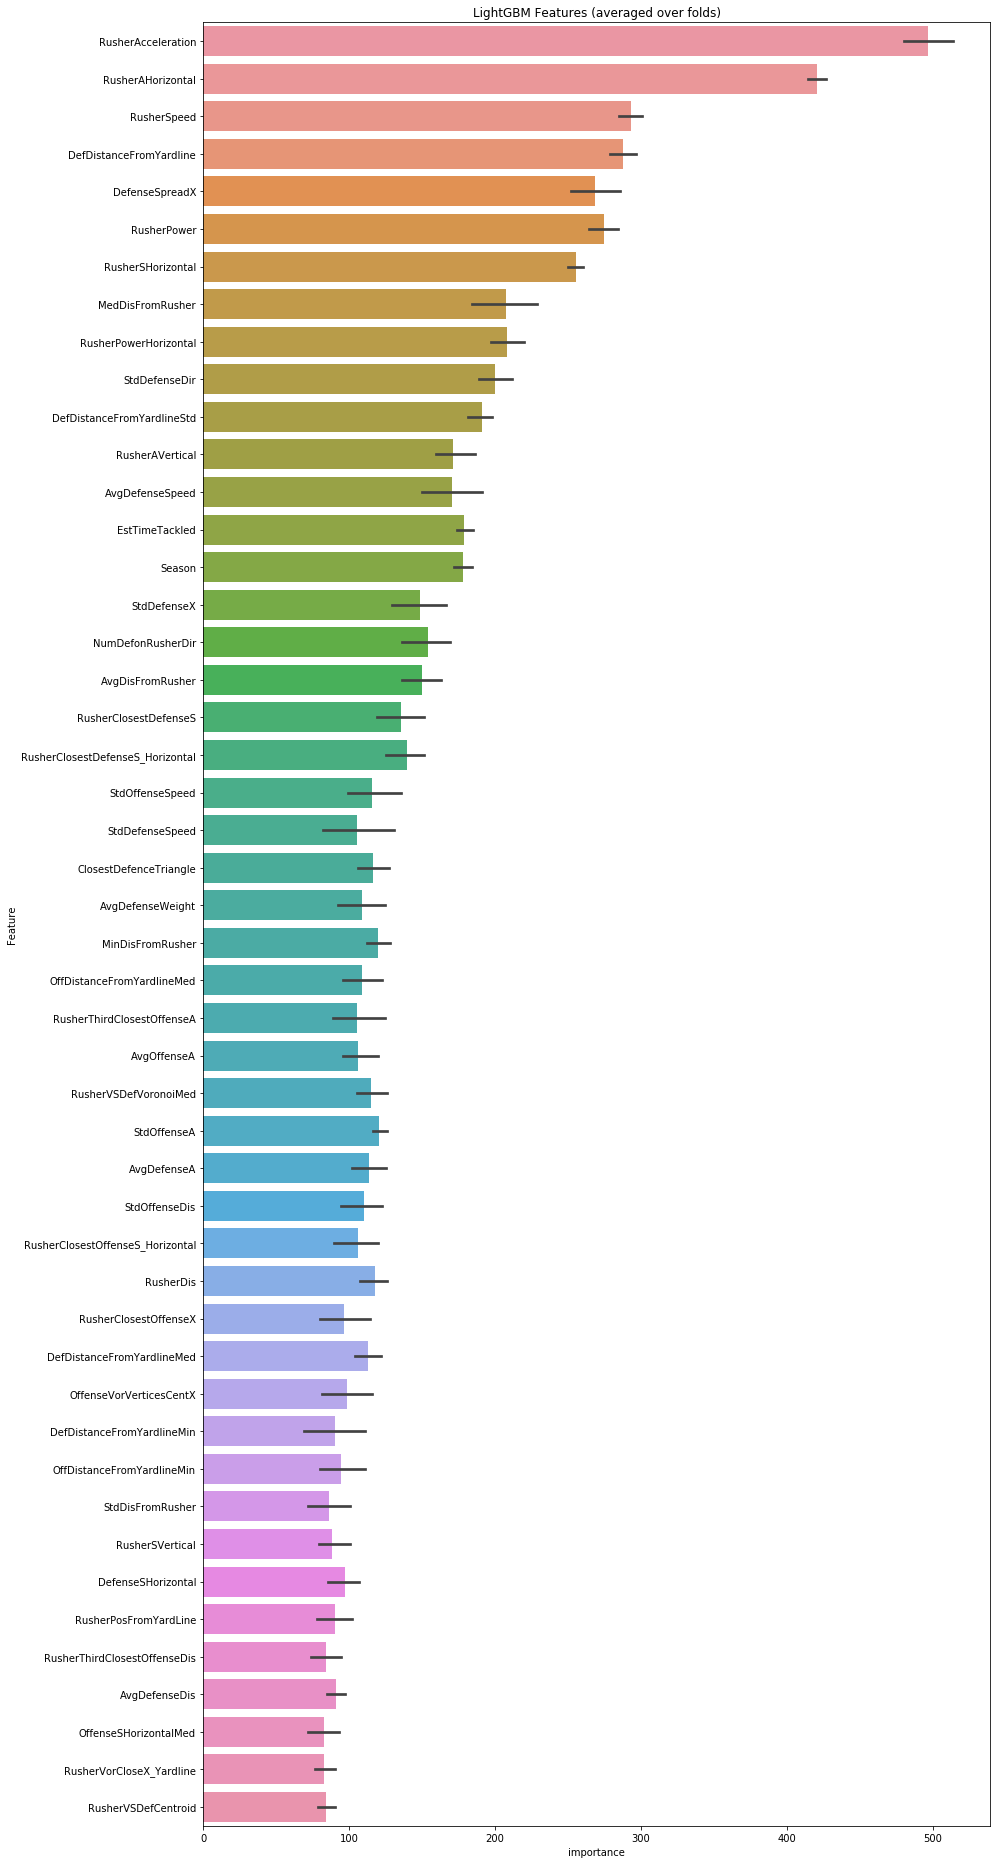

In [25]:
import seaborn as sns

cols_imp = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:48].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols_imp)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [26]:
feature_name = cols_imp

In [27]:
X_train = X_gameid.join(X_features)

print(X_train.shape)
print(y_train.shape)
X_train.head()

X_train_2017 = X_train.query("Season < 1.0")
X_train_2018 = X_train.query("Season >= 1.0")

X_train[feature_name].to_csv('train_feat.csv')
X_train_2017.to_csv('train17.csv')
X_train_2018.to_csv('train18.csv')

(31007, 199)
(31007, 199)


## NN Model
NeuralNetwork model 

In [28]:
class CRPSCallback(Callback):
    
    def __init__(self,validation, predict_batch_size=20, include_on_batch=False):
        super(CRPSCallback, self).__init__()
        self.validation = validation
        self.predict_batch_size = predict_batch_size
        self.include_on_batch = include_on_batch
        
        print('validation shape',len(self.validation))

    def on_batch_begin(self, batch, logs={}):
        pass

    def on_train_begin(self, logs={}):
        if not ('CRPS_score_val' in self.params['metrics']):
            self.params['metrics'].append('CRPS_score_val')

    def on_batch_end(self, batch, logs={}):
        if (self.include_on_batch):
            logs['CRPS_score_val'] = float('-inf')

    def on_epoch_end(self, epoch, logs={}):
        logs['CRPS_score_val'] = float('-inf')
            
        if (self.validation):
            X_valid, y_valid = self.validation[0], self.validation[1]
            y_pred = self.model.predict(X_valid)
            y_true = np.clip(np.cumsum(y_valid, axis=1), 0, 1)
            y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1)
            val_s = ((y_true - y_pred) ** 2).sum(axis=1).sum(axis=0) / (199 * X_valid.shape[0])
            val_s = np.round(val_s, 6)
            logs['CRPS_score_val'] = val_s

In [29]:
#PARAMS
INPUT_SIZE = X_train[feature_name].shape[1]
OUTPUT_SIZE = 199
print(INPUT_SIZE)
BATCH_SIZE = 512
EPOCHS = 50

def get_model(x_tr, y_tr, x_val, y_val):
    model = Sequential()
    

    model.add(Dense(1024, input_shape=(INPUT_SIZE,)))
    model.add(Activation('relu'))
    model.add(Dropout(0.7))
    model.add(BatchNormalization())
    model.add(Dense(512, input_shape=(INPUT_SIZE,)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(384))
    model.add(Activation('relu'))
    model.add(Dropout(0.35))
    model.add(BatchNormalization())
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dense(OUTPUT_SIZE))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=[])
    
    es = EarlyStopping(monitor='CRPS_score_val', 
                       mode='min',
                       restore_best_weights=True, 
                       verbose=1, 
                       patience=12)
    
    mc = ModelCheckpoint('best_model.h5',monitor='CRPS_score_val',mode='min',
                         save_best_only=True, verbose=1, save_weights_only=True)
    
    model.fit(x_tr, y_tr,
         batch_size = BATCH_SIZE,
         epochs=EPOCHS,
         callbacks = [CRPSCallback(validation = (x_val, y_val)), es, mc],
         verbose=1)
    
    y_pred = model.predict(x_val)
    y_valid = y_val
    y_true = np.clip(np.cumsum(y_valid, axis=1), 0, 1)
    y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1)
    val_s = ((y_true - y_pred) ** 2).sum(axis=1).sum(axis=0) / (199 * x_val.shape[0])
    crps = np.round(val_s, 6)
    
    return model ,crps

48


In [30]:
from sklearn.model_selection import train_test_split, KFold, GroupKFold
from sklearn.model_selection import TimeSeriesSplit
import time

losses = []
models = []
crps_csv = []


#tscv = TimeSeriesSplit(n_splits=5)

# for tr_inds, val_inds in tscv.split(yards_train):
#     print(len(tr_inds), len(val_inds))
#     tr_x,tr_y = X_train.iloc[tr_inds][feature_name],y_train[tr_inds]
#     val_x,val_y = X_train.iloc[val_inds][feature_name],y_train[val_inds]
#     model,crps = get_model(tr_x,tr_y,val_x,val_y)
#     models.append(model)
#     print("crps is %f"%(crps))
#     crps_csv.append(crps)


kfold = KFold(5, shuffle=True, random_state=42)
for k_fold, (tr_inds, val_inds) in enumerate(kfold.split(yards_train)):
    print(len(tr_inds), len(val_inds))
    tr_x,tr_y = X_train.iloc[tr_inds][feature_name],y_train[tr_inds]
    val_x,val_y = X_train.iloc[val_inds][feature_name],y_train[val_inds]
    model,crps = get_model(tr_x,tr_y,val_x,val_y)
    models.append(model)
    print("the %d fold crps is %f"%((k_fold+1),crps))
    crps_csv.append(crps)
        
print("mean crps is %f"%np.mean(crps_csv))
print(len(models))

24805 6202
validation shape 2
Epoch 1/50
24805/24805 [==============================] - 4s 163us/step - loss: 5.3387

Epoch 00001: CRPS_score_val improved from inf to 0.07152, saving model to best_model.h5
Epoch 2/50
24805/24805 [==============================] - 3s 108us/step - loss: 4.2790

Epoch 00002: CRPS_score_val improved from 0.07152 to 0.03196, saving model to best_model.h5
Epoch 3/50
24805/24805 [==============================] - 3s 108us/step - loss: 3.3952

Epoch 00003: CRPS_score_val improved from 0.03196 to 0.01488, saving model to best_model.h5
Epoch 4/50
24805/24805 [==============================] - 3s 106us/step - loss: 2.9870

Epoch 00004: CRPS_score_val improved from 0.01488 to 0.01305, saving model to best_model.h5
Epoch 5/50
24805/24805 [==============================] - 3s 106us/step - loss: 2.8776

Epoch 00005: CRPS_score_val improved from 0.01305 to 0.01285, saving model to best_model.h5
Epoch 6/50
24805/24805 [==============================] - 3s 107us/step - 

## Submission
**This part only works under Kaggle kernel environment since it calls original API for this competition.**

In [31]:
def predict(x_te):
    model_num = len(models)
    for k,m in enumerate(models):
        if k==0:
            y_pred = m.predict(x_te,batch_size=BATCH_SIZE)
        else:
            y_pred+=m.predict(x_te,batch_size=BATCH_SIZE)
            
    y_pred = y_pred / model_num
    
    return y_pred

In [32]:
from kaggle.competitions import nflrush
env = nflrush.make_env()
iter_test = env.iter_test()
row_count = 0

for (test_df, sample_prediction_df) in iter_test:
    basetable = get_data(test_df, mode='test')
    for c in basetable.columns:
        if(basetable[c].dtype != int):
            basetable[c] = basetable[c].astype('float32')
            
    for c in basetable.columns:
        if basetable[c].isnull().any():
            print(c)
            print(basetable[c].mean())
            basetable[c] = basetable[c].fillna(0)
    #print(basetable.isnull().any(), row_count)
    basetable.drop(['PlayId', 'GameId'], axis=1, inplace=True)
    scaled_basetable = scaler.transform(basetable)
    scaled_basetable = pd.DataFrame(scaled_basetable, index=basetable.index, columns=basetable.columns)
    
    y_pred = predict(scaled_basetable[feature_name])
    y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1).tolist()[0]
    
    preds_df = pd.DataFrame(data=[y_pred], columns=sample_prediction_df.columns)
    env.predict(preds_df)
    row_count += 1
    
env.write_submission_file()
    

100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


Your submission file has been saved!  Once you `Commit` your Notebook and it finishes running, you can submit the file to the competition from the Notebook Viewer `Output` tab.
